# India Experiments

In [1]:
%load_ext autoreload
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = Path(".").absolute().parents[0]
assert base_dir.name == "spatio_temporal"
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    get_pollution_data_beijing,
    create_test_oxford_run_data
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in Data
```python
import sys; sys.path.append("/Users/tommylees/github/concept_formation")
from scripts.data_process.clip_netcdf_to_shapefile import prepare_rio_data, rasterize_all_geoms, create_timeseries_of_masked_datasets
from spatio_temporal.data.data_utils import interpolate_missing_values_in_time, encode_sample_str_as_int

# 1. prepare_rio_data 2. rasterize_all_geoms 3. create_timeseries_of_masked_datasets
# see notebooks/drafts/india_regions.ipynb
ds, lookup = encode_sample_str_as_int(ds, sample_str="region")
ds = interpolate_missing_values_in_time(ds, sample_dim="region")
```

In [9]:
ds = xr.open_dataset(base_dir / "data/data_india_regions.nc").sortby("time")
ds

<xarray.Dataset>
Dimensions:        (region: 36, time: 206)
Coordinates:
    spatial_ref    int64 ...
  * time           (time) datetime64[ns] 2001-11-30 2001-12-31 ... 2018-12-31
  * region         (region) int64 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35
Data variables:
    VCI            (time, region) float64 ...
    swvl1          (time, region) float32 ...
    swvl2          (time, region) float32 ...
    swvl3          (time, region) float32 ...
    swvl4          (time, region) float32 ...
    pev            (time, region) float32 ...
    tp             (time, region) float32 ...
    t2m            (time, region) float32 ...
    e              (time, region) float32 ...
    t2m_std_1      (time, region) float64 ...
    t2m_mean_1     (time, region) float64 ...
    t2m_std_2      (time, region) float64 ...
    t2m_mean_2     (time, region) float64 ...
    t2m_std_3      (time, region) float64 ...
    t2m_mean_3     (time, region) float64 ...
    erate_std_1    (time, region) float64 ...
    erate_mean_1   (time, region) float64 ...
    erate_std_2    (time, region) float64 ...
    erate_mean_2   (time, region) float64 ...
    erate_std_3    (time, region) float64 ...
    erate_mean_3   (time, region) float64 ...
    tprate_std_1   (time, region) float64 ...
    tprate_mean_1  (time, region) float64 ...
    tprate_std_2   (time, region) float64 ...
    tprate_mean_2  (time, region) float64 ...
    tprate_std_3   (time, region) float64 ...
    tprate_mean_3  (time, region) float64 ...
    modis_vci      (time, region) float64 ...

# check the config

In [24]:
cfg = Config(base_dir / "configs/india_region.yml")
cfg._cfg["n_epochs"] = 3

# Work with subset of data

In [13]:
print("Loading Trainer")
trainer = Trainer(cfg, ds)

/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Loading Data:  47%|████▋     | 17/36 [00:00<00:00, 165.80it/s]

Loading Trainer


Loading Data: 100%|██████████| 36/36 [00:00<00:00, 478.55it/s]


In [14]:
losses = trainer.train_and_validate()

Training Epoch 2:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.43
Valid Loss: 0.47


Training Epoch 3:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.42
Valid Loss: 0.47


Validation Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

Train Loss: 0.41
Valid Loss: 0.46


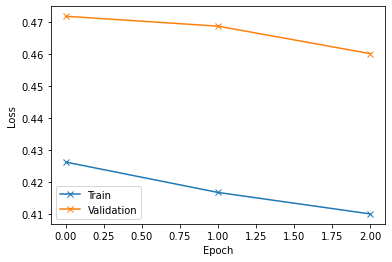

In [31]:
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_loss_curves

# save_loss_curves(losses, cfg)
_plot_loss_curves(losses);

Test set Forward Pass: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


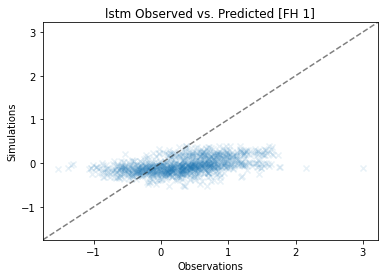

In [17]:
tester = Tester(cfg, ds)
preds = tester.run_test(unnormalize=True)

# Check hold-out test performance

In [29]:
cfg.run_dir = Path(base_dir / "notebooks/runs/india_region_1803_165022")
xr_path = sorted(list(cfg.run_dir.glob("*.nc")))[-1]
preds = xr.open_dataset(xr_path).drop("horizon").drop("spatial_ref")
preds

<xarray.Dataset>
Dimensions:  (pixel: 35, time: 31)
Coordinates:
  * time     (time) datetime64[ns] 2016-05-31T00:00:42.290642944 ... 2018-11-...
  * pixel    (pixel) object '0_0' '10_10' '11_11' '12_12' ... '7_7' '8_8' '9_9'
Data variables:
    sim      (time, pixel) float64 ...
    obs      (time, pixel) float64 ...

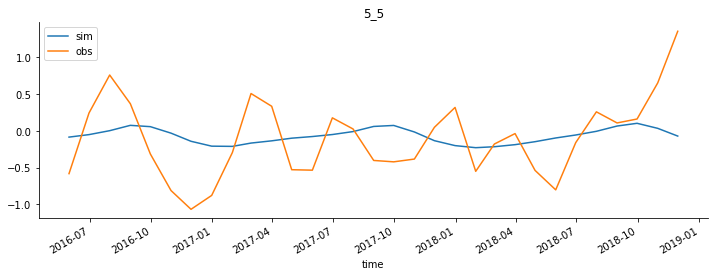

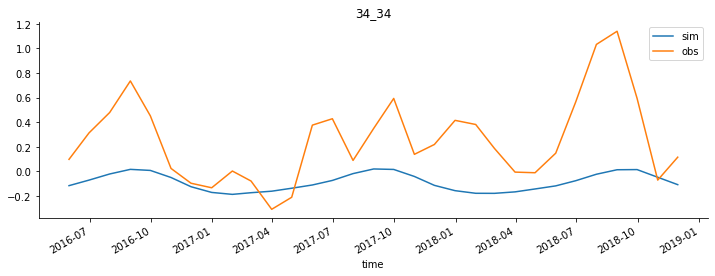

In [33]:
from spatio_temporal.training.eval_utils import save_timeseries

for _ in range(2):
    save_timeseries(preds, cfg)
    sns.despine()

In [22]:
# from ml_drought
import sys; sys.path.append("/Users/tommylees/github/ml_drought")
import sys; sys.path.append("/Users/tommylees/github/neuralhydrology")
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict
from spatio_temporal.data.data_utils import unstack_xarray


errors = calculate_all_data_errors(
    preds.rename({"pixel":"station_id"}), decompose_kge=False, yilmaz_errors=True
)["sim"].to_xarray().rename({"station_id": "pixel"})
spatial_errors = unstack_xarray(errors, sample_str="pixel")

Errors:   0%|          | 0/1 [00:00<?, ?it/s]/Users/tommylees/github/ml_drought/scripts/drafts/water_closure_levels.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime(dt.year, 1, 1).year
/Users/tommylees/github/ml_drought/scripts/drafts/water_closure_levels.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime(dt.year + 1, 1, 1).year
/Users/tommylees/github/ml_drought/scripts/drafts/calculate_error_scores.py:109: RuntimeWarning: invalid value encountered in log
  np.log(d["obs"].values + epsilon), np.log(d["sim"].values + epsilon)
/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tommylees/miniconda3/envs/ml/li

In [23]:
spatial_errors

<xarray.Dataset>
Dimensions:       (lat: 5, lon: 5)
Coordinates:
  * lat           (lat) float64 35.6 35.7 35.8 35.9 36.0
  * lon           (lon) float64 67.3 67.4 67.5 67.6 67.7
Data variables:
    pixel         (lat, lon) object '35.599998474121094_67.30000305175781' .....
    nse           (lat, lon) float64 -0.1759 -0.02817 ... -0.5319 -0.2653
    kge           (lat, lon) float64 -3.642 -0.827 -1.842 ... -1.108 -1.037
    mse           (lat, lon) float64 0.6785 0.6898 0.745 ... 0.8154 0.5356 0.544
    bias          (lat, lon) float64 -446.1 137.4 248.8 ... -104.3 -129.1 -122.9
    pbias         (lat, lon) float64 446.1 -137.4 -248.8 ... 104.3 129.1 122.9
    log_nse       (lat, lon) float64 nan nan nan nan ... -0.01133 -118.7 -1.147
    inv_kge       (lat, lon) float64 -5.559 -9.235 -0.4227 ... -4.104 -0.8708
    sqrt_kge      (lat, lon) float64 nan nan nan ... 0.0004857 -0.6581 -0.9738
    abs_pct_bias  (lat, lon) float64 446.1 137.4 248.8 ... 104.3 129.1 122.9
    mape          (lat, lon) float64 97.43 123.8 384.0 ... 140.2 119.1 145.6
    bias_error    (lat, lon) float64 -4.461 1.374 2.488 ... -1.043 -1.291 -1.229
    std_error     (lat, lon) float64 -0.9086 -0.9168 -0.899 ... -0.8176 -0.8466
    fms           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    flv           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    fhv           (lat, lon) float64 -110.3 -113.9 -110.1 ... -81.78 -85.19
    mam30_ape     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    rmse          (lat, lon) float64 0.8237 0.8306 0.8631 ... 0.7319 0.7376

# Evaluate previously run experiment

In [78]:
assert False, "From here you're working with a pre-run experiment"
from spatio_temporal.data.data_utils import unstack_xarray

AssertionError: From here you're working with a pre-run experiment

In [88]:
import pickle 
lookup = pickle.load((base_dir / "data/india_regionL1_lookup.pkl").open("rb"))

In [89]:
run_dir = sorted(list((base_dir / "runs").glob("*india_region*")))[-1]

cfg = Config(run_dir / "config.yml")

In [102]:
preds = xr.open_dataset(list((run_dir.glob("*.nc")))[0])
preds = unstack_xarray(preds, "pixel", latlon=False)
preds["pixel"] = [lookup[p] for p in preds["pixel"].values]
preds = preds.drop(["index", "time", "horizon", "spatial_ref"])
preds

<xarray.Dataset>
Dimensions:  (pixel: 35, time: 31)
Coordinates:
  * pixel    (pixel) <U22 'Andaman and Nicobar' ... 'West Bengal'
Dimensions without coordinates: time
Data variables:
    sim      (time, pixel) float64 0.4775 -0.4656 0.2891 ... -0.1651 0.03825
    obs      (time, pixel) float64 0.3736 -0.09264 0.4398 ... 0.1145 0.1545

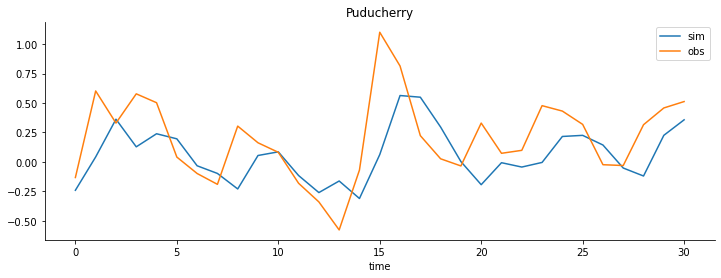

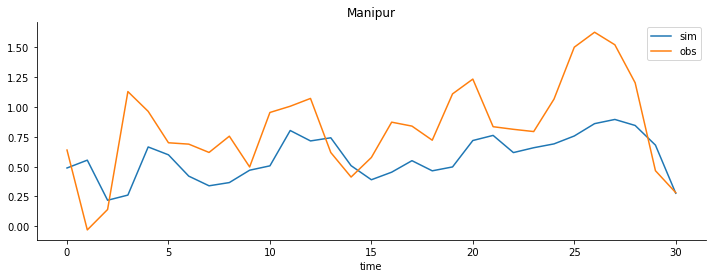

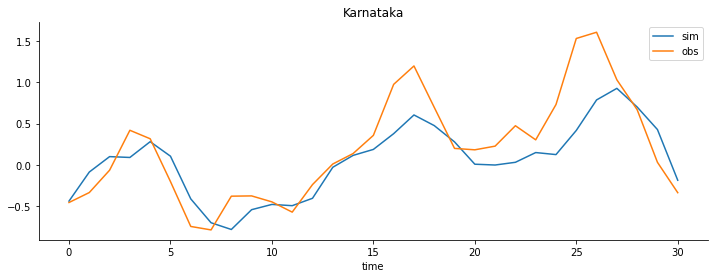

In [104]:
from spatio_temporal.training.eval_utils import _plot_single_timeseries

for _ in range(3):
    _plot_single_timeseries(preds)
    sns.despine()